In [1]:
%load_ext autoreload
%autoreload

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')


In [3]:
df_gaming = pd.read_csv('data/gaming_reviews.tsv', sep='\t', error_bad_lines=False)


b'Skipping line 20630: expected 15 fields, saw 22\nSkipping line 28172: expected 15 fields, saw 22\nSkipping line 54791: expected 15 fields, saw 22\n'
b'Skipping line 75419: expected 15 fields, saw 22\nSkipping line 104832: expected 15 fields, saw 22\n'
b'Skipping line 138464: expected 15 fields, saw 22\nSkipping line 194849: expected 15 fields, saw 22\n'
b'Skipping line 201568: expected 15 fields, saw 22\nSkipping line 242567: expected 15 fields, saw 22\n'
b'Skipping line 493585: expected 15 fields, saw 22\nSkipping line 502478: expected 15 fields, saw 22\n'
b'Skipping line 660750: expected 15 fields, saw 22\n'


In [4]:
df_gaming.head()


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,Video Games,5,0,0,N,Y,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",2015-08-31
1,US,9636577,R1ZV7R40OLHKD,B00M920ND6,569686175,Tonsee 6 buttons Wireless Optical Silent Gamin...,Video Games,5,0,0,N,Y,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",2015-08-31
2,US,2331478,R3BH071QLH8QMC,B0029CSOD2,98937668,Hidden Mysteries: Titanic Secrets of the Fatef...,Video Games,1,0,1,N,Y,One Star,poor quality work and not as it is advertised.,2015-08-31
3,US,52495923,R127K9NTSXA2YH,B00GOOSV98,23143350,GelTabz Performance Thumb Grips - PlayStation ...,Video Games,3,0,0,N,Y,"good, but could be bettee","nice, but tend to slip away from stick in inte...",2015-08-31
4,US,14533949,R32ZWUXDJPW27Q,B00Y074JOM,821342511,Zero Suit Samus amiibo - Japan Import (Super S...,Video Games,4,0,0,N,Y,Great but flawed.,"Great amiibo, great for collecting. Quality ma...",2015-08-31


In [0]:
df_gaming.loc[0:100, 'product_title']


In [0]:
df_gaming.columns


In [0]:
df_gaming[0:100]


In [0]:
len(df_gaming.loc[:, 'product_title'].unique())


In [0]:
df_gaming.info()


<bound method Axes.set_xlabel of <matplotlib.axes._subplots.AxesSubplot object at 0x7f7de85b85f8>>

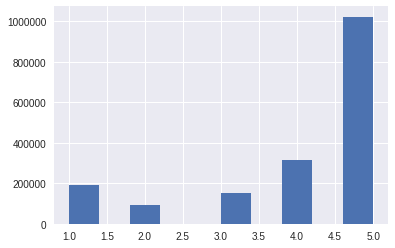

In [5]:
ax = plt.subplot()
ax.hist(df_gaming.loc[:, 'star_rating'])
ax.set_xlabel


In [0]:
df_gaming.loc[:, 'star_rating'].describe()


In [0]:
ratings = 